In [16]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format ='retina'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Import data

In [17]:
#btc options data
df=pd.read_csv('data/btc_data.csv', sep=",", index_col=0)
df = df.reset_index(drop=False)
#df.drop(columns=['Unnamed: 0', 'interest_rate'], inplace=True)

In [18]:
import QuantLib as ql
import pandas as pd
from datetime import datetime

btc_options_data = df

# Filter and rename the relevant columns
btc_options_filtered = btc_options_data[['underlying_price', 'Strike Price', 'mark_iv', 'Expiration Date', 'best_bid_price', 'best_ask_price']]
btc_options_filtered.columns = ['Spot Price', 'Strike Price', 'Implied Volatility', 'Expiration Date', 'Bid Price', 'Ask Price']

# Define the helper function to calculate the option price using the BSM model
def calculate_bsm_option_price(spot_price, strike_price, time_to_expiry, risk_free_rate, volatility, option_type="call"):
    today = ql.Date.todaysDate()
    ql.Settings.instance().evaluationDate = today
    
    spot_handle = ql.QuoteHandle(ql.SimpleQuote(spot_price))
    payoff = ql.PlainVanillaPayoff(ql.Option.Call if option_type == "call" else ql.Option.Put, strike_price)
    maturity_date = ql.Date(4, 2, 2024)  # Placeholder, we will update this dynamically below
    exercise = ql.EuropeanExercise(maturity_date)
    option = ql.VanillaOption(payoff, exercise)
    
    risk_free_curve = ql.YieldTermStructureHandle(ql.FlatForward(today, risk_free_rate, ql.Actual365Fixed()))
    volatility_handle = ql.BlackVolTermStructureHandle(ql.BlackConstantVol(today, ql.NullCalendar(), ql.QuoteHandle(ql.SimpleQuote(volatility / 100)), ql.Actual365Fixed()))
    
    bsm_process = ql.BlackScholesProcess(spot_handle, risk_free_curve, volatility_handle)
    engine = ql.AnalyticEuropeanEngine(bsm_process)
    option.setPricingEngine(engine)
    
    return option.NPV()

# Function to calculate time to expiration in years from the expiration date
def calculate_time_to_expiry(expiration_date_str):
    expiration_date = datetime.strptime(expiration_date_str, '%d%b%y')  # Format: e.g., "4FEB24"
    today = datetime.today()
    delta = expiration_date - today
    return delta.days / 365.0  # Time to expiration in years

# Now iterate over the dataset and calculate the option price for each row
calculated_prices = []

for index, row in btc_options_filtered.iterrows():
    spot_price = row['Spot Price']
    strike_price = row['Strike Price']
    implied_volatility = row['Implied Volatility']
    expiration_date = row['Expiration Date']
    risk_free_rate = 0.01  # Assuming a constant 1% risk-free rate
    
    # Calculate the time to expiry dynamically from the expiration date
    time_to_expiry = calculate_time_to_expiry(expiration_date)
    
    # Skip rows with very small or zero time to expiry
    if time_to_expiry <= 0:
        continue
    
    # Calculate the call and put prices
    call_price = calculate_bsm_option_price(spot_price, strike_price, time_to_expiry, risk_free_rate, implied_volatility, option_type="call")
    put_price = calculate_bsm_option_price(spot_price, strike_price, time_to_expiry, risk_free_rate, implied_volatility, option_type="put")
    
    # Store the results
    calculated_prices.append({
        'Spot Price': spot_price,
        'Strike Price': strike_price,
        'Call Price': call_price,
        'Put Price': put_price
    })

# Convert results to a DataFrame
calculated_prices_df = pd.DataFrame(calculated_prices)

# Save or display the calculated prices
calculated_prices_df.to_csv('calculated_option_prices.csv', index=False)
print(calculated_prices_df)


    Spot Price  Strike Price  Call Price  Put Price
0   67051.2112         62000         0.0        0.0
1   67051.2112         62000         0.0        0.0
2   67053.1887         63000         0.0        0.0
3   67053.1887         63000         0.0        0.0
4   67054.6835         64000         0.0        0.0
..         ...           ...         ...        ...
73  68249.6938        100000         0.0        0.0
74  68247.9308        105000         0.0        0.0
75  68247.9308        105000         0.0        0.0
76  68245.6977        110000         0.0        0.0
77  68245.6977        110000         0.0        0.0

[78 rows x 4 columns]


In [10]:
import QuantLib as ql
import pandas as pd


btc_options_data = df

# Filter and rename the relevant columns
btc_options_filtered = btc_options_data[['underlying_price', 'Strike Price', 'mark_iv', 'Expiration Date', 'best_bid_price', 'best_ask_price']]
btc_options_filtered.columns = ['Spot Price', 'Strike Price', 'Implied Volatility', 'Expiration Date', 'Bid Price', 'Ask Price']

# Define the helper function to calculate the option price using the BSM model
def calculate_bsm_option_price(spot_price, strike_price, time_to_expiry, risk_free_rate, volatility, option_type="call"):
    today = ql.Date.todaysDate()
    ql.Settings.instance().evaluationDate = today
    
    spot_handle = ql.QuoteHandle(ql.SimpleQuote(spot_price))
    payoff = ql.PlainVanillaPayoff(ql.Option.Call if option_type == "call" else ql.Option.Put, strike_price)
    maturity_date = ql.Date(4, 2, 2024)  # Fixed expiration for now; adapt this later if needed.
    exercise = ql.EuropeanExercise(maturity_date)
    option = ql.VanillaOption(payoff, exercise)
    
    risk_free_curve = ql.YieldTermStructureHandle(ql.FlatForward(today, risk_free_rate, ql.Actual365Fixed()))
    volatility_handle = ql.BlackVolTermStructureHandle(ql.BlackConstantVol(today, ql.NullCalendar(), ql.QuoteHandle(ql.SimpleQuote(volatility / 100)), ql.Actual365Fixed()))
    
    bsm_process = ql.BlackScholesProcess(spot_handle, risk_free_curve, volatility_handle)
    engine = ql.AnalyticEuropeanEngine(bsm_process)
    option.setPricingEngine(engine)
    
    return option.NPV()

# Now iterate over the dataset and calculate the option price for each row
calculated_prices = []

for index, row in btc_options_filtered.iterrows():
    spot_price = row['Spot Price']
    strike_price = row['Strike Price']
    implied_volatility = row['Implied Volatility']
    risk_free_rate = 0.01  # Assuming a constant 1% risk-free rate
    
    # Use approximate time to expiry; adjust this if you want more accuracy with the dates
    time_to_expiry = 30 / 365  # Assuming 30 days to expiry as an approximation for now
    
    # Calculate the call and put prices
    call_price = calculate_bsm_option_price(spot_price, strike_price, time_to_expiry, risk_free_rate, implied_volatility, option_type="call")
    put_price = calculate_bsm_option_price(spot_price, strike_price, time_to_expiry, risk_free_rate, implied_volatility, option_type="put")
    
    # Store the results
    calculated_prices.append({
        'Spot Price': spot_price,
        'Strike Price': strike_price,
        'Call Price': call_price,
        'Put Price': put_price
    })

# Convert results to a DataFrame
calculated_prices_df = pd.DataFrame(calculated_prices)

#

     Spot Price  Strike Price  Call Price  Put Price
0    43046.8715         38500         0.0        0.0
1    43046.6290         38500         0.0        0.0
2    43046.8715         39000         0.0        0.0
3    43046.8715         39000         0.0        0.0
4    43046.8715         39500         0.0        0.0
..          ...           ...         ...        ...
653  46185.0600        110000         0.0        0.0
654  46185.0600        120000         0.0        0.0
655  46185.0600        120000         0.0        0.0
656  46185.2600        130000         0.0        0.0
657  46185.0000        130000         0.0        0.0

[658 rows x 4 columns]


In [2]:
import QuantLib as ql

# Option parameters
option_type = ql.Option.Call  # Call or Put option
strike_price = 100  # Strike price
underlying_price = 100  # Underlying asset price
risk_free_rate = 0.05  # Risk-free rate (5%)
volatility = 0.20  # Volatility of the underlying asset (20%)
dividend_yield = 0.0  # Dividend yield
maturity_date = ql.Date(15, 9, 2025)  # Option expiry

# Create the payoff and exercise style
payoff = ql.PlainVanillaPayoff(option_type, strike_price)
exercise = ql.EuropeanExercise(maturity_date)

# Construct the option
option = ql.VanillaOption(payoff, exercise)

# Set up the market environment
# Create a YieldTermStructureHandle for the risk-free rate
calendar = ql.UnitedStates()
settlement_date = ql.Date(15, 9, 2024)
day_count = ql.Actual365Fixed()

risk_free_curve = ql.YieldTermStructureHandle(
    ql.FlatForward(settlement_date, risk_free_rate, day_count)
)

# Create a Black-Scholes process
volatility_handle = ql.BlackVolTermStructureHandle(
    ql.BlackConstantVol(settlement_date, calendar, volatility, day_count)
)
dividend_curve = ql.YieldTermStructureHandle(
    ql.FlatForward(settlement_date, dividend_yield, day_count)
)

underlying_handle = ql.QuoteHandle(ql.SimpleQuote(underlying_price))
bsm_process = ql.BlackScholesMertonProcess(
    underlying_handle, dividend_curve, risk_free_curve, volatility_handle
)

# Price the option using the analytic Black-Scholes formula
option.setPricingEngine(ql.AnalyticEuropeanEngine(bsm_process))

# Calculate the option price
option_price = option.NPV()

print(f"The BSM price of the option is: {option_price}")


TypeError: UnitedStates.__init__() missing 1 required positional argument: 'm'

In [3]:
# Convert date column
df['Expiration_Date'] = pd.to_datetime(df['Expiration Date'], format='%d%b%y')

### Black-Scholes model

* Stock Price (S): In cryptocurrency, this would be the current price of the crypto asset.

* Strike Price (K): The price at which the option can be exercised.

* Time to Expiration (T): The remaining life of the option, usually in years.

* Risk-free Rate (r): The rate of return on a risk-free investment, typically treasury bills.

* Volatility (σ): This is where most adjustments for cryptocurrencies will be made, reflecting the asset's price variability.

In [4]:
# Convert Expiration Date to datetime
df['Expiration Date'] = pd.to_datetime(df['Expiration Date'])

df['Time to Expiration'] = (df['Expiration Date'] - pd.Timestamp('2024-02-03')).dt.days / 365

# Use average implied volatility or calculate it if not directly provided
df['Implied Volatility'] = (df['bid_iv'] + df['ask_iv']) / 2 / 100  # converting percentage to decimal


C:\Users\Ethan Vaz Falcao\AppData\Local\Temp\ipykernel_25488\1112640718.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Expiration Date'] = pd.to_datetime(df['Expiration Date'])


In [5]:
df[['Expiration_Date', 'Expiration Date', 'Time to Expiration']].head()

,Expiration_Date,Expiration Date,Time to Expiration
0,2024-02-04,2024-02-04,0.00274
1,2024-02-04,2024-02-04,0.00274
2,2024-02-04,2024-02-04,0.00274
3,2024-02-04,2024-02-04,0.00274
4,2024-02-04,2024-02-04,0.00274


In [6]:
# Example: Using a simple moving average for volatility
df['SMA Volatility'] = df['Implied Volatility'].rolling(window=30).mean()  # 30-day simple moving average

In [7]:
from scipy.stats import norm

def black_scholes_call(S, K, T, r, sigma):
    """ Calculate the Black-Scholes option price for a call option """
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

# Risk-free rate - As crypto does not have a clear risk-free rate, you may use a proxy like U.S. Treasury rates or a stablecoin yield
risk_free_rate = 0.02  # 2%


In [8]:
# Apply the model to each option in the dataframe
df['BS Price'] = df.apply(lambda x: black_scholes_call(x['underlying_price'], x['Strike Price'], x['Time to Expiration'], risk_free_rate, x['Implied Volatility']), axis=1)


C:\Users\Ethan Vaz Falcao\AppData\Local\Temp\ipykernel_25488\4222010145.py:5: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))


In [9]:
# Apply the model to each option in the dataframe
df['BS Price_1'] = df.apply(lambda x: black_scholes_call(x['underlying_price'], x['Strike Price'], x['Time to Expiration'], risk_free_rate, x['SMA Volatility']), axis=1)


C:\Users\Ethan Vaz Falcao\AppData\Local\Temp\ipykernel_25488\4222010145.py:5: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))


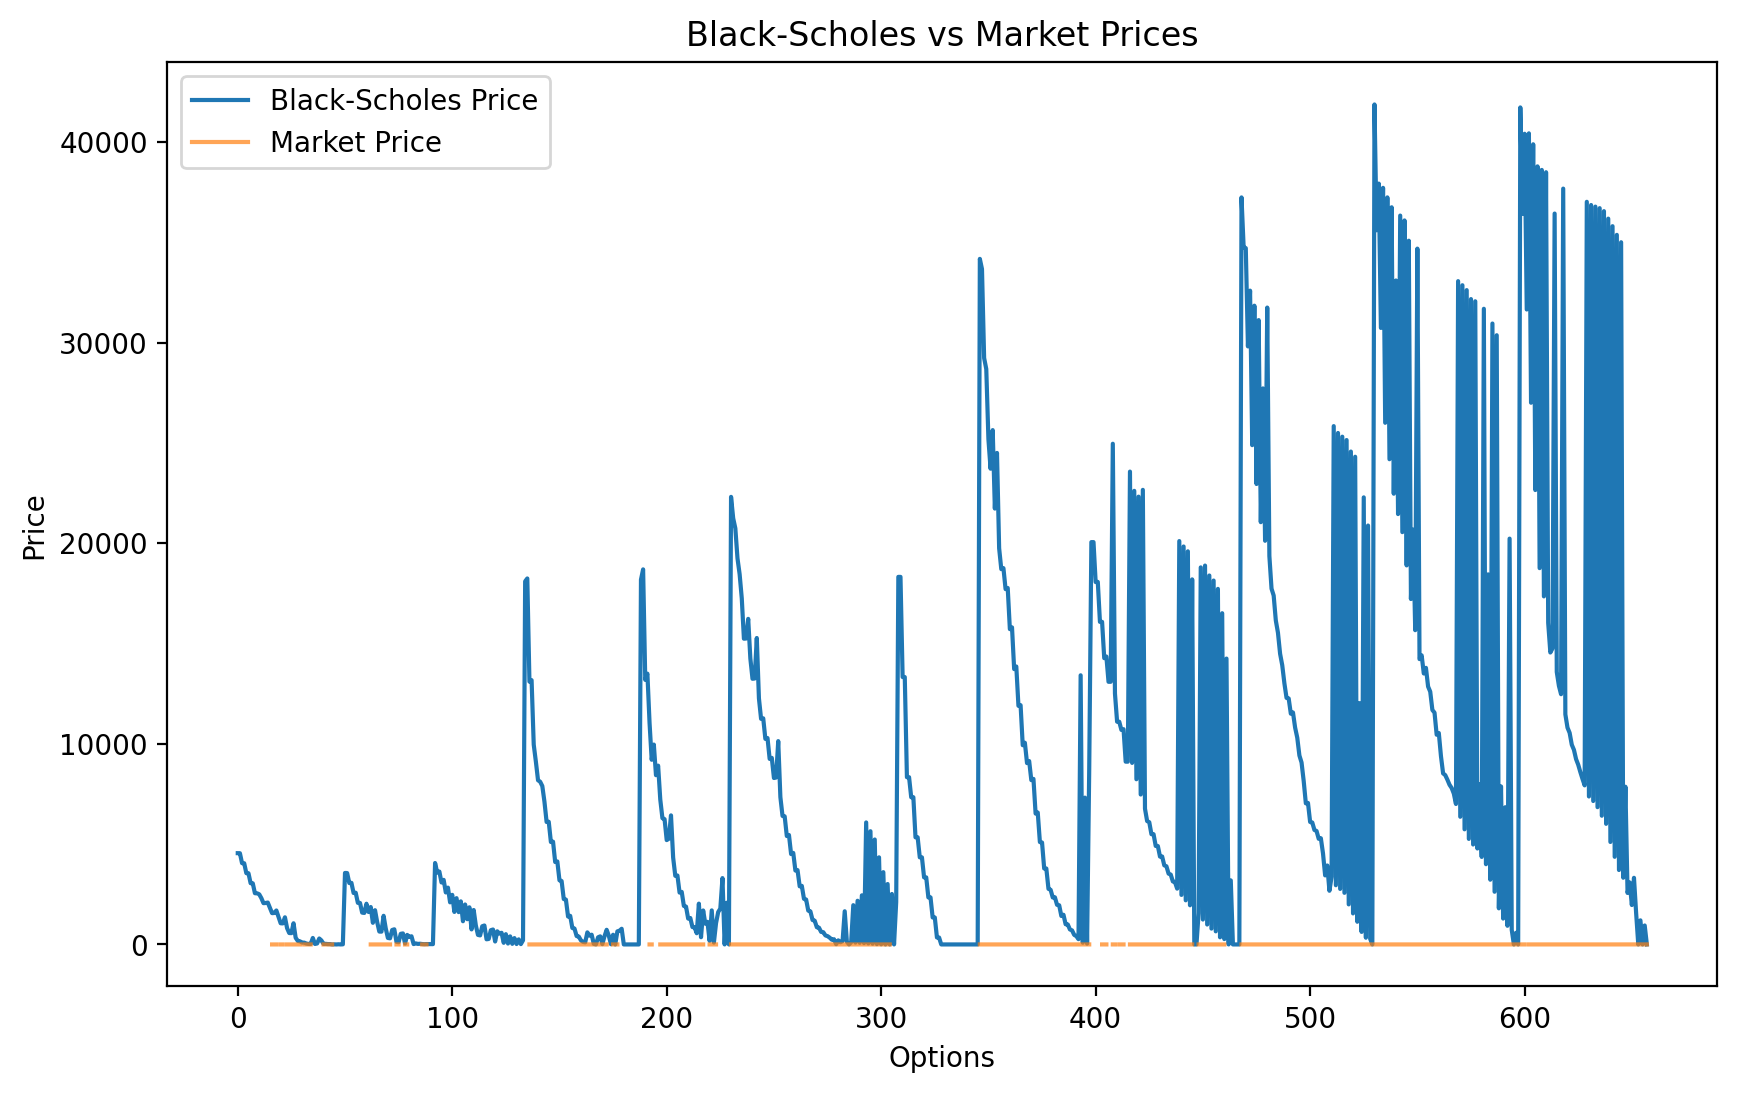

In [10]:
# Assume 'last_price' is the market price of the option
df['Market Price'] = df['last_price']  # or whatever the actual market price field is

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(df['BS Price'], label='Black-Scholes Price')
plt.plot(df['Market Price'], label='Market Price', alpha=0.7)
plt.title('Black-Scholes vs Market Prices')
plt.xlabel('Options')
plt.ylabel('Price')
plt.legend()
plt.show()


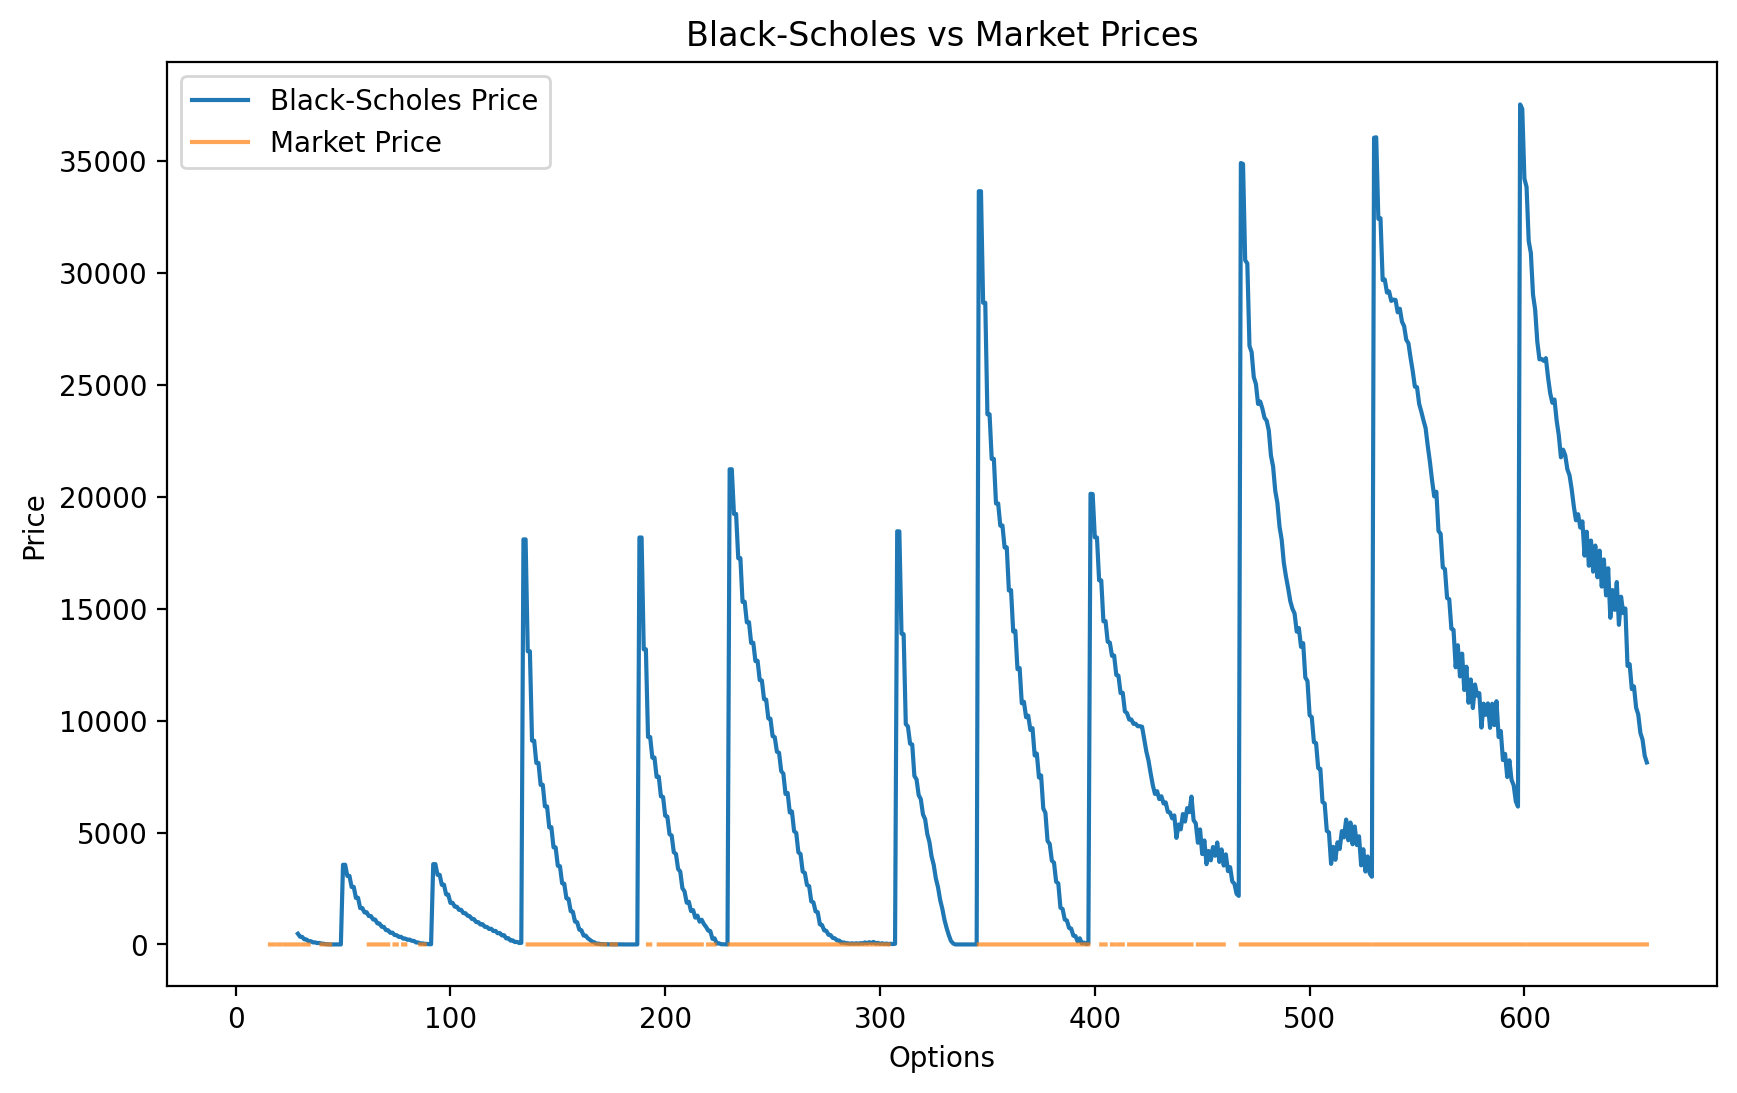

In [11]:
# Assume 'last_price' is the market price of the option
df['Market Price'] = df['last_price']  # or whatever the actual market price field is

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(df['BS Price_1'], label='Black-Scholes Price')
plt.plot(df['Market Price'], label='Market Price', alpha=0.7)
plt.title('Black-Scholes vs Market Prices')
plt.xlabel('Options')
plt.ylabel('Price')
plt.legend()
plt.show()


In [12]:
# Example: Calibrating volatility
from scipy.optimize import minimize

def mse(x, market_prices, S, K, T, r):
    sigma = x
    estimated_prices = [black_scholes_call(s, k, t, r, sigma) for s, k, t in zip(S, K, T)]
    return ((market_prices - estimated_prices) ** 2).mean()

initial_guess = 0.5
result = minimize(mse, initial_guess, args=(df['Market Price'].values, df['underlying_price'].values, df['Strike Price'].values, df['Time to Expiration'].values, risk_free_rate))
optimal_sigma = result.x


In [13]:
from scipy.optimize import minimize

# Define the Black-Scholes call pricing function
from scipy.stats import norm
import numpy as np

def black_scholes_call(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

# Function to calculate mean squared error between theoretical and market prices
def mse(sigma, market_prices, S, K, T, r):
    estimated_prices = [black_scholes_call(s, k, t, r, sigma) for s, k, t in zip(S, K, T)]
    return np.mean((np.array(market_prices) - np.array(estimated_prices)) ** 2)

# Example data preparation: Assume df contains the relevant data
market_prices = df['Market Price'].values
underlying_prices = df['underlying_price'].values
strike_prices = df['Strike Price'].values
times_to_expiration = df['Time to Expiration'].values
risk_free_rate = 0.02  # Example rate, adjust according to your needs

# Optimize for the best sigma (volatility) using minimize
initial_guess = 0.5  # Initial guess for volatility
result = minimize(mse, initial_guess, args=(market_prices, underlying_prices, strike_prices, times_to_expiration, risk_free_rate))
optimal_sigma = result.x[0]

print(f"The optimal volatility (sigma) is: {optimal_sigma}")


The optimal volatility (sigma) is: 0.5


In [14]:
from scipy.stats import norm
import numpy as np
# Assuming you have already obtained the optimal volatility
sigma = 0.5  # Extract the optimal volatility value



# Define a safe version of the Black-Scholes Call pricing function
def black_scholes_call_safe(S, K, T, r, sigma):
    # Ensure parameters are within valid ranges
    if S <= 0 or K <= 0 or T <= 0 or sigma <= 0:
        return np.nan  # Return NaN if any parameter is invalid
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

In [15]:
# Check for missing or zero values in relevant columns
print(df[['underlying_price', 'Strike Price', 'Time to Expiration']].isnull().sum())
print(df[['underlying_price', 'Strike Price', 'Time to Expiration']].min())


underlying_price      0
Strike Price          0
Time to Expiration    0
dtype: int64
underlying_price      43045.74260
Strike Price          10000.00000
Time to Expiration        0.00274
dtype: float64


##### Filter out rows with zero or negative values in critical columns
##### Drop rows where Market Price is Null

In [16]:
df.isnull().sum()

best_bid_amount         0
best_ask_amount         0
bid_iv                  0
ask_iv                  0
underlying_index        0
underlying_price        0
mark_iv                 0
interest_rate           0
best_bid_price          0
best_ask_price          0
open_interest           0
max_price               0
min_price               0
last_price            157
asks                    0
bids                    0
settlement_price       42
instrument_name         0
mark_price              0
index_price             0
change_id               0
timestamp               0
greeks.rho              0
greeks.theta            0
greeks.vega             0
greeks.gamma            0
greeks.delta            0
stats.volume_usd        0
stats.volume            0
stats.price_change    361
stats.low             361
stats.high            361
settlement_period       0
Expiration Date         0
Strike Price            0
Expiration_Date         0
Time to Expiration      0
Implied Volatility      0
SMA Volatili

####   Black-Scholes Model 

In [17]:
import numpy as np
from scipy.stats import norm

# Define a function to calculate Black-Scholes option price
def black_scholes_call(S, K, T, r, sigma):
    """Calculate the Black-Scholes European call option price."""
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call_price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    return call_price

# Apply the Black-Scholes formula to each row
def apply_black_scholes(row):
    S = row['underlying_price']
    K = row['Strike Price']
    T = float(row['Time to Expiration'])
    r = float(row['interest_rate'])
    sigma = float(row['Implied Volatility'])
    
    return black_scholes_call(S, K, T, r, sigma)

# Create a new column with the calculated Black-Scholes prices
df['Calculated_BS_Price'] = df.apply(apply_black_scholes, axis=1)

# Display the first few rows with the new column
df[['Expiration_Date','underlying_price', 'Strike Price', 'Time to Expiration', 'Implied Volatility', 'interest_rate', 'Calculated_BS_Price']].head()


C:\Users\Ethan Vaz Falcao\AppData\Local\Temp\ipykernel_25488\3020594971.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))


,Expiration_Date,underlying_price,Strike Price,Time to Expiration,Implied Volatility,interest_rate,Calculated_BS_Price
0,2024-02-04,43046.8715,38500,0.00274,0.75550,0.0,4548.005568
1,2024-02-04,43046.6290,38500,0.00274,0.55005,0.0,4546.643338
2,2024-02-04,43046.8715,39000,0.00274,0.69625,0.0,4048.407898
3,2024-02-04,43046.8715,39000,0.00274,0.45220,0.0,4046.874702
4,2024-02-04,43046.8715,39500,0.00274,0.63460,0.0,3548.949395


In [18]:
# Example: Calculate the Mean Absolute Error (MAE)
from sklearn.metrics import mean_absolute_error

df['Market Price'].fillna(method='ffill', inplace=True)
df = df.dropna(subset=['Market Price'])


mae = mean_absolute_error(df['Market Price'], df['Calculated_BS_Price'])
print(f"Mean Absolute Error (MAE): {mae}")

Mean Absolute Error (MAE): 8229.943717246193


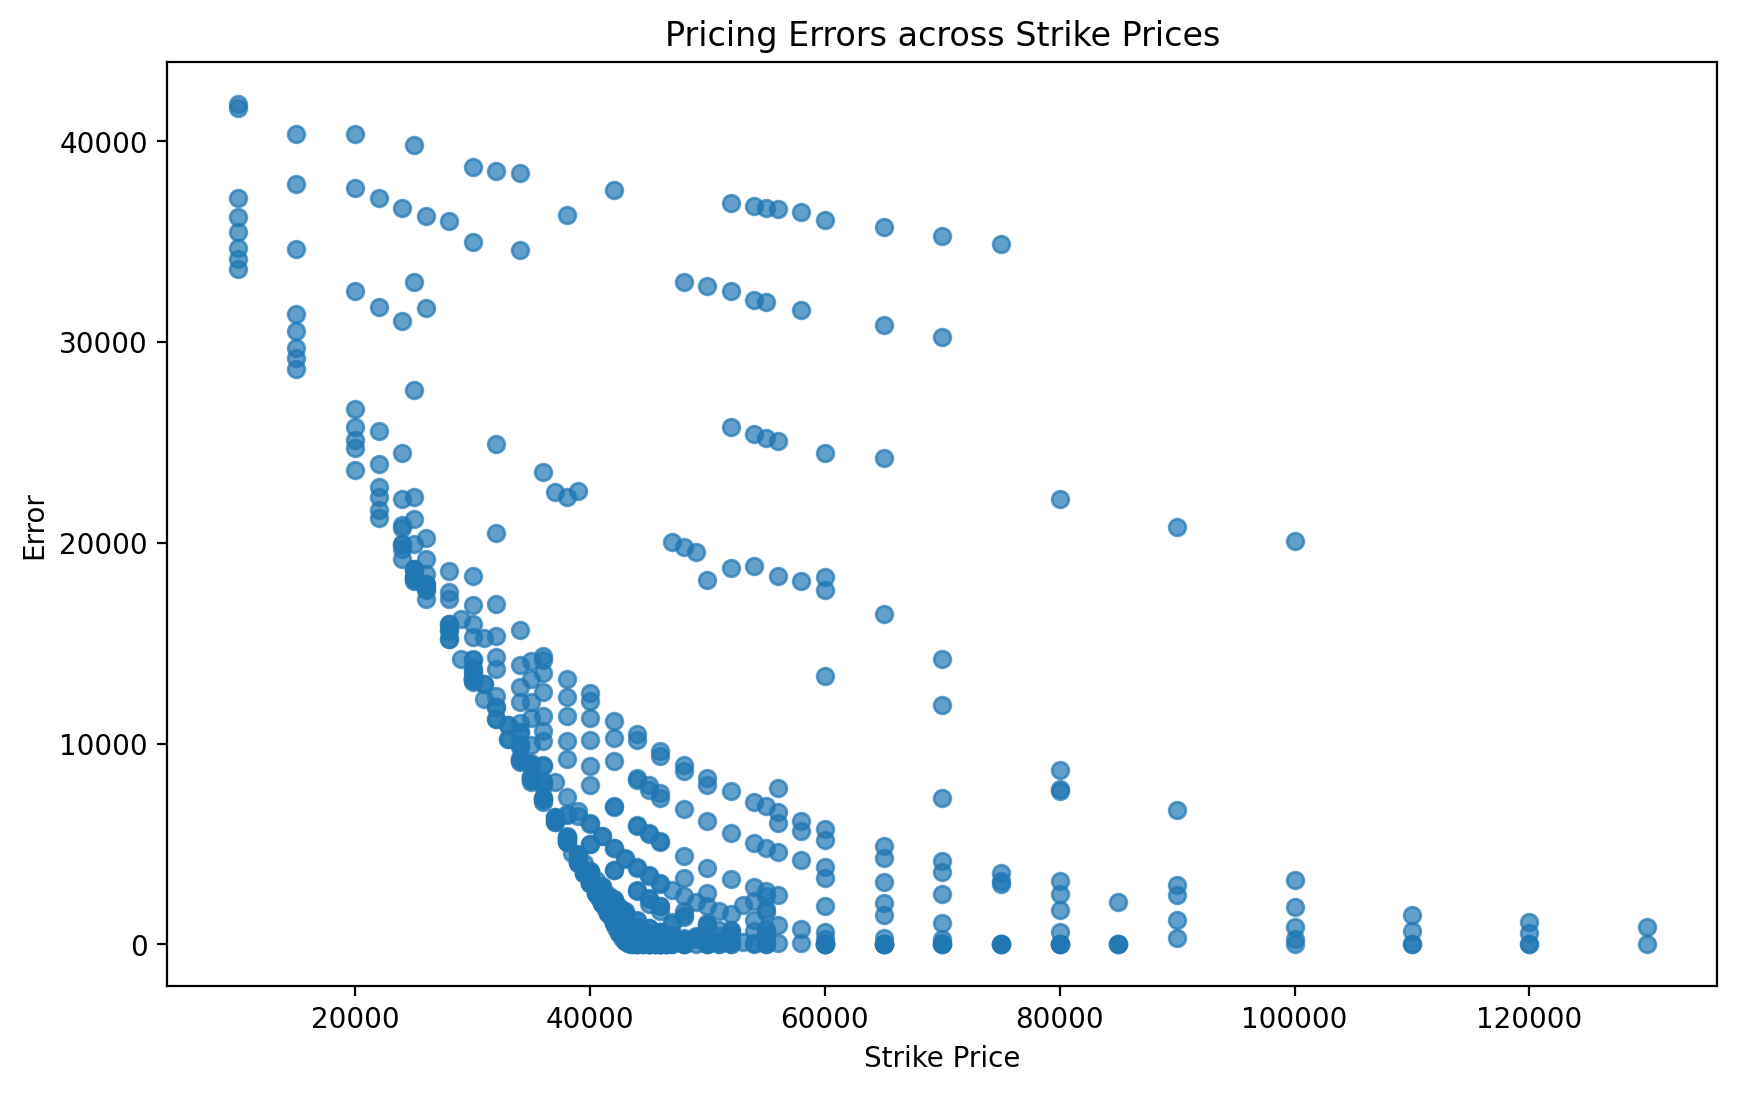

In [19]:
import matplotlib.pyplot as plt

# Calculate residuals
df['Error'] = abs(df['Market Price'] - df['Calculated_BS_Price'])

# Plot residuals
plt.figure(figsize=(10, 6))
plt.plot(df['Strike Price'], df['Error'], 'o', alpha=0.7)
plt.xlabel('Strike Price')
plt.ylabel('Error')
plt.title('Pricing Errors across Strike Prices')
plt.show()


#### Improve Calibration with Optimization

To improve the calibration of your Black-Scholes model using optimization techniques, I refine the volatility parameter (sigma) to minimize pricing errors across all strikes. This involves finding the optimal value for volatility that minimizes the discrepancy between theoretical prices and actual market prices. 

In [20]:
import numpy as np
from scipy.optimize import minimize
from scipy.stats import norm

# Define Black-Scholes call option pricing function
def black_scholes_call(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call_price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    return call_price

# Error function to minimize
def pricing_error(params, market_prices, S, K, T, r):
    sigma = params[0]  # Optimize the sigma (volatility)
    theoretical_prices = np.array([black_scholes_call(s, k, t, r, sigma) for s, k, t in zip(S, K, T)])
    error = np.mean(np.abs(market_prices - theoretical_prices))  # Mean Absolute Error
    return error

# Extract relevant data from the DataFrame
market_prices = df['Market Price'].values
underlying_prices = df['underlying_price'].values
strike_prices = df['Strike Price'].values
times_to_expiration = df['Time to Expiration'].values
interest_rate = 0.01  # Example interest rate; adjust to your data

# Initial guess for sigma (volatility)
initial_sigma = 0.2

# Minimize the error function to calibrate the Black-Scholes model
result = minimize(pricing_error, [initial_sigma], args=(market_prices, underlying_prices, strike_prices, times_to_expiration, interest_rate))
optimal_sigma = result.x[0]

print(f"Optimized Sigma (Volatility): {optimal_sigma}")

# Apply the optimized sigma back to the DataFrame
def apply_optimized_bs(row):
    S = row['underlying_price']
    K = row['Strike Price']
    T = row['Time to Expiration']
    r = interest_rate
    return black_scholes_call(S, K, T, r, optimal_sigma)

df['Optimized_BS_Price'] = df.apply(apply_optimized_bs, axis=1)

# Display updated DataFrame with optimized price
df[['Expiration_Date', 'underlying_price', 'Strike Price', 'Time to Expiration', 'Market Price', 'Optimized_BS_Price']].head()


Optimized Sigma (Volatility): 0.00046002924519172503


,Expiration_Date,underlying_price,Strike Price,Time to Expiration,Market Price,Optimized_BS_Price
1,2024-02-04,43046.6290,38500,0.00274,0.0002,4547.683780
2,2024-02-04,43046.8715,39000,0.00274,0.0002,4047.939979
3,2024-02-04,43046.8715,39000,0.00274,0.0001,4047.939979
4,2024-02-04,43046.8715,39500,0.00274,0.0001,3547.953677
5,2024-02-04,43046.8715,39500,0.00274,0.0001,3547.953677


In [21]:

mae = mean_absolute_error(df['Market Price'], df['Optimized_BS_Price'])
print(f"Mean Absolute Error (MAE): {mae}")

Mean Absolute Error (MAE): 4841.9472645979085


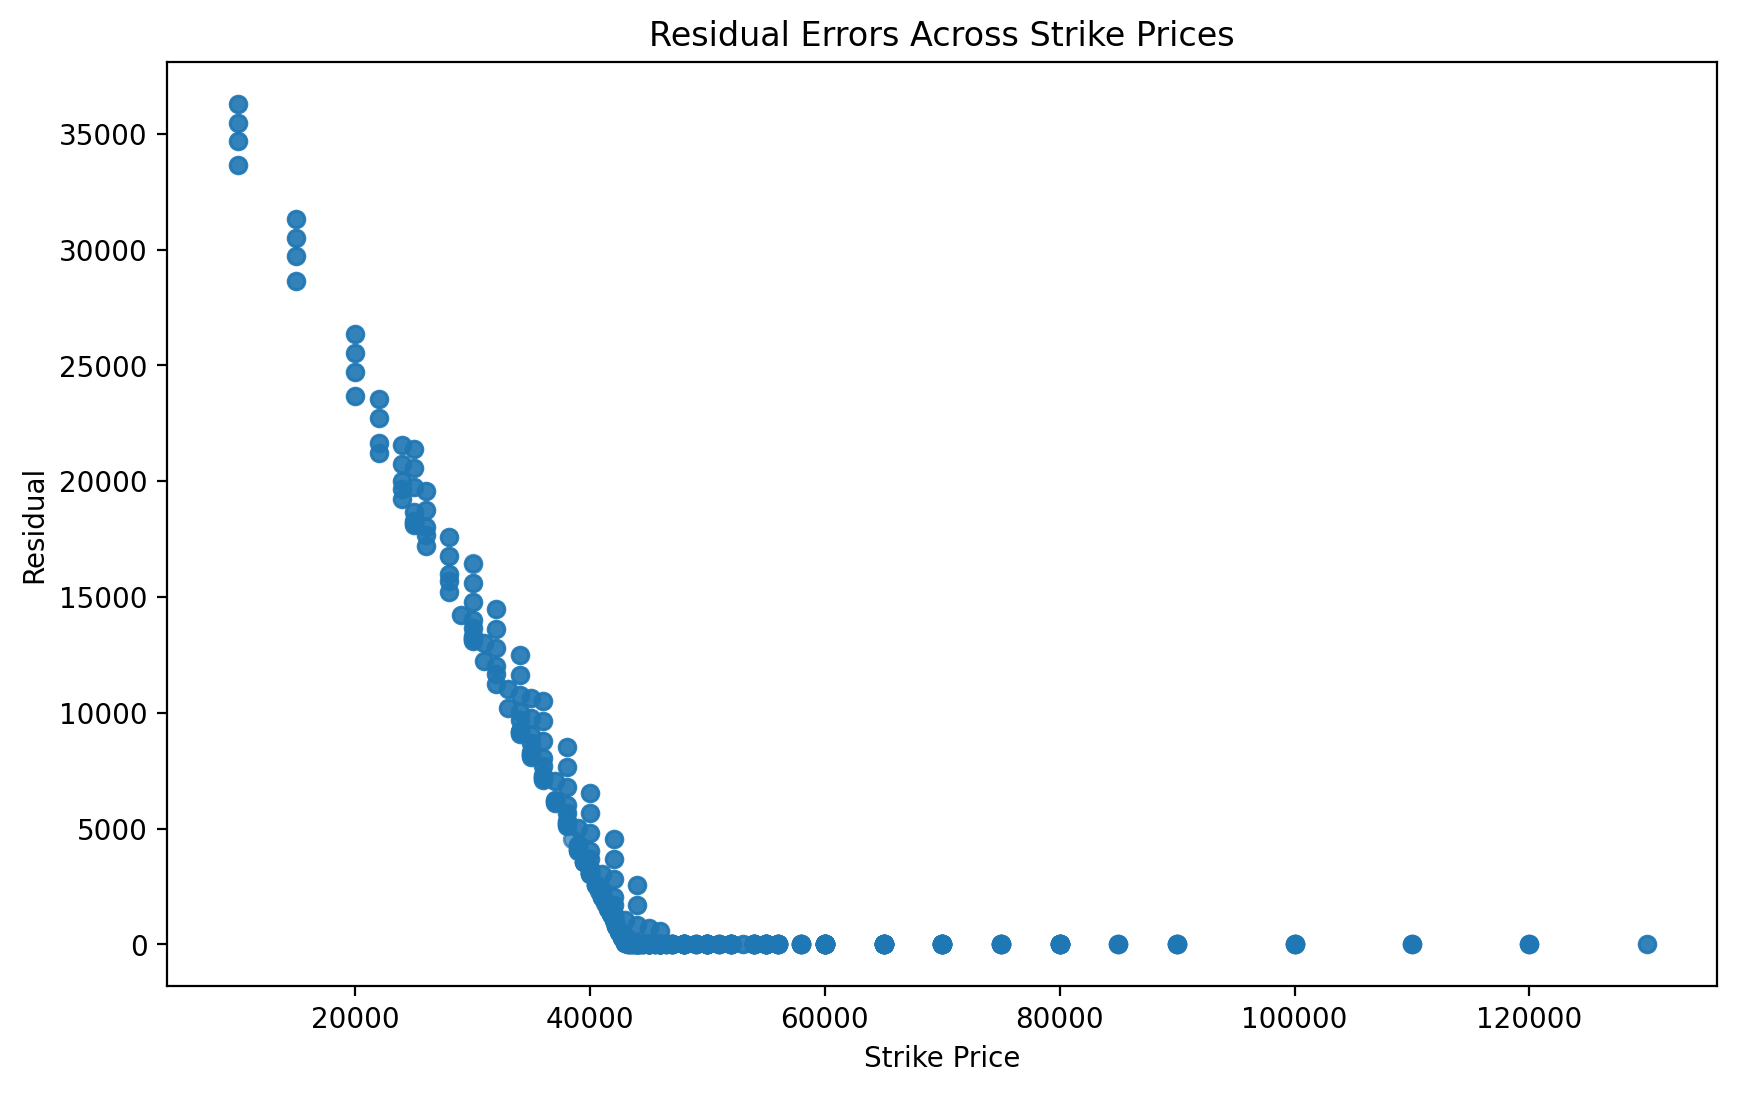

In [22]:
import matplotlib.pyplot as plt

# Calculate residuals
df['Residual'] = abs(df['Market Price'] - df['Optimized_BS_Price'])

# Plot residuals against strike price
plt.figure(figsize=(10, 6))
plt.plot(df['Strike Price'], df['Residual'], 'o', alpha=0.7)
plt.xlabel('Strike Price')
plt.ylabel('Residual')
plt.title('Residual Errors Across Strike Prices')
plt.show()


In [23]:
df.to_csv('data/btc_data_bsm.csv')

### Heston model

The Heston model is a stochastic volatility model that allows the volatility itself to vary over time, making it a more sophisticated tool than the Black-Scholes model. It accounts for the fact that financial markets often exhibit volatility clustering and mean reversion. 

In [24]:
from scipy.integrate import quad
from numpy import exp, sqrt, log, pi

def heston_characteristic_function(u, t, S, K, r, kappa, theta, sigma, rho, v0):
    """
    Heston characteristic function for computing European option prices.
    u: Complex number input
    t: Time to maturity
    S: Underlying asset price
    K: Strike price
    r: Risk-free rate
    kappa, theta, sigma, rho, v0: Heston parameters
    """
    i = 1j  # Imaginary unit
    x = log(S / K)
    
    # Parameters
    a = kappa * theta
    b = kappa + rho * sigma * u * i
    d = sqrt((rho * sigma * u * i - b) ** 2 - (u * i + u**2) * sigma**2)
    g = (b - rho * sigma * u * i + d) / (b - rho * sigma * u * i - d)
    
    # Calculate the exponential terms
    C = r * u * t * i + a / sigma**2 * ((b - rho * sigma * u * i + d) * t - 2 * log((1 - g * exp(d * t)) / (1 - g)))
    D = (b - rho * sigma * u * i + d) / sigma**2 * ((1 - exp(d * t)) / (1 - g * exp(d * t)))
    
    # The characteristic function
    return exp(C + D * v0 + u * i * x)

# Helper function to integrate the characteristic function and compute option prices
def heston_option_price(S, K, r, T, kappa, theta, sigma, rho, v0, option_type='call'):
    """
    Compute the Heston model option price via numerical integration.
    S: Underlying price
    K: Strike price
    r: Risk-free rate
    T: Time to expiration
    kappa, theta, sigma, rho, v0: Heston parameters
    option_type: 'call' or 'put'
    """
    def integrand(phi, type_flag):
        u = phi - 1j if type_flag == 'call' else phi
        P = exp(-1j * phi * log(K)) * heston_characteristic_function(u, T, S, K, r, kappa, theta, sigma, rho, v0) / (1j * phi)
        return P.real

    # Perform numerical integration
    integral_call = 0.5 + quad(lambda phi: integrand(phi, 'call'), 0, 100)[0] / pi
    option_price = S * integral_call - K * exp(-r * T) * (0.5 + quad(lambda phi: integrand(phi, 'put'), 0, 100)[0] / pi)

    return option_price if option_type == 'call' else max(K * exp(-r * T) - option_price, 0)

# Test the Heston option pricing function with example parameters
S_test = 100
K_test = 105
r_test = 0.01
T_test = 1
kappa_test, theta_test, sigma_test, rho_test, v0_test = 2.0, 0.04, 0.3, -0.7, 0.04

heston_option_price(S_test, K_test, r_test, T_test, kappa_test, theta_test, sigma_test, rho_test, v0_test)


C:\Users\Ethan Vaz Falcao\AppData\Local\Temp\ipykernel_20848\139220639.py:47: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  integral_call = 0.5 + quad(lambda phi: integrand(phi, 'call'), 0, 100)[0] / pi
C:\Users\Ethan Vaz Falcao\AppData\Local\Temp\ipykernel_20848\139220639.py:48: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will

-2.26385582830511e+24

In [25]:
# Adjust the integration bounds and retry
def heston_option_price_adjusted(S, K, r, T, kappa, theta, sigma, rho, v0, option_type='call'):
    """
    Compute the Heston model option price via numerical integration with adjusted bounds.
    S: Underlying price
    K: Strike price
    r: Risk-free rate
    T: Time to expiration
    kappa, theta, sigma, rho, v0: Heston parameters
    option_type: 'call' or 'put'
    """
    def integrand(phi, type_flag):
        u = phi - 1j if type_flag == 'call' else phi
        P = exp(-1j * phi * log(K)) * heston_characteristic_function(u, T, S, K, r, kappa, theta, sigma, rho, v0) / (1j * phi)
        return P.real

    # Perform numerical integration with adjusted bounds
    integral_call = 0.5 + quad(lambda phi: integrand(phi, 'call'), 0, 20)[0] / pi
    option_price = S * integral_call - K * exp(-r * T) * (0.5 + quad(lambda phi: integrand(phi, 'put'), 0, 20)[0] / pi)

    return option_price if option_type == 'call' else max(K * exp(-r * T) - option_price, 0)

# Test the adjusted Heston option pricing function
heston_option_price_adjusted(S_test, K_test, r_test, T_test, kappa_test, theta_test, sigma_test, rho_test, v0_test)


-23154.687423665277

In [26]:
def heston_cos_price(S, K, r, T, kappa, theta, sigma, rho, v0, N=1000, option_type='call'):
    """
    Compute the Heston model option price via the Fourier-Cosine (COS) method.
    S: Underlying price
    K: Strike price
    r: Risk-free rate
    T: Time to expiration
    kappa, theta, sigma, rho, v0: Heston parameters
    N: Number of terms in the series
    option_type: 'call' or 'put'
    """
    # Define constants
    c1 = r * T + (1 - np.exp(-kappa * T)) * (theta - v0) / (2 * kappa)
    c2 = (sigma**2 * T * np.exp(-2 * kappa * T) + (v0 - theta)**2) / (8 * kappa)
    L = 10 * sqrt(c2)  # Typically chosen as a multiple of the standard deviation
    
    # Interval for the expansion
    a, b = c1 - L, c1 + L
    
    # Coefficients in the COS series
    def cos_coefficients(k):
        return 2 / (b - a) * (exp(-r * T) * (np.cos(pi * k * (b - a) / (b - a)) - np.cos(pi * k * (a - b) / (b - a))))

    # Compute the COS series expansion terms
    cos_terms = np.array([cos_coefficients(k) for k in range(N)])
    
    # Compute the characteristic function expansion terms
    characteristic_terms = np.array([heston_characteristic_function(k * pi / (b - a), T, S, K, r, kappa, theta, sigma, rho, v0) for k in range(N)])
    
    # Calculate the option price using the COS expansion
    price = sum(cos_terms * characteristic_terms)

    return price if option_type == 'call' else max(K * exp(-r * T) - price, 0)

# Test the Heston COS method
heston_cos_price(S_test, K_test, r_test, T_test, kappa_test, theta_test, sigma_test, rho_test, v0_test)


C:\Users\Ethan Vaz Falcao\AppData\Local\Temp\ipykernel_20848\139220639.py:21: RuntimeWarning: divide by zero encountered in scalar divide
  g = (b - rho * sigma * u * i + d) / (b - rho * sigma * u * i - d)
C:\Users\Ethan Vaz Falcao\AppData\Local\Temp\ipykernel_20848\139220639.py:21: RuntimeWarning: invalid value encountered in scalar divide
  g = (b - rho * sigma * u * i + d) / (b - rho * sigma * u * i - d)
C:\Users\Ethan Vaz Falcao\AppData\Local\Temp\ipykernel_20848\139220639.py:24: RuntimeWarning: invalid value encountered in scalar multiply
  C = r * u * t * i + a / sigma**2 * ((b - rho * sigma * u * i + d) * t - 2 * log((1 - g * exp(d * t)) / (1 - g)))
C:\Users\Ethan Vaz Falcao\AppData\Local\Temp\ipykernel_20848\139220639.py:24: RuntimeWarning: invalid value encountered in scalar divide
  C = r * u * t * i + a / sigma**2 * ((b - rho * sigma * u * i + d) * t - 2 * log((1 - g * exp(d * t)) / (1 - g)))
C:\Users\Ethan Vaz Falcao\AppData\Local\Temp\ipykernel_20848\139220639.py:24: Runti

(nan+nanj)

In [27]:
df

,best_bid_amount,best_ask_amount,bid_iv,ask_iv,underlying_index,underlying_price,mark_iv,interest_rate,best_bid_price,best_ask_price,...,Time to Expiration,Implied Volatility,SMA Volatility,BS Price,BS Price_1,Market Price,Calculated_BS_Price,Error,Optimized_BS_Price,Residual
1,0.0,92.5,0.00,110.01,SYN.BTC-4FEB24,43046.6290,85.49,0.0,0.0000,0.0002,...,0.00274,0.55005,NaN,4548.752751,NaN,0.0002,4546.643338,4546.643138,4547.683780,4547.683580
2,0.0,19.8,0.00,139.25,SYN.BTC-4FEB24,43046.8715,78.77,0.0,0.0000,0.0955,...,0.00274,0.69625,NaN,4050.537228,NaN,0.0002,4048.407898,4048.407698,4047.939979,4047.939779
3,0.0,1.5,0.00,90.44,SYN.BTC-4FEB24,43046.8715,78.77,0.0,0.0000,0.0001,...,0.00274,0.45220,NaN,4049.011595,NaN,0.0001,4046.874702,4046.874602,4047.939979,4047.939879
4,0.0,20.7,0.00,126.92,SYN.BTC-4FEB24,43046.8715,66.52,0.0,0.0000,0.0840,...,0.00274,0.63460,NaN,3551.102807,NaN,0.0001,3548.949395,3548.949295,3547.953677,3547.953577
5,0.0,26.8,0.00,80.04,SYN.BTC-4FEB24,43046.8715,66.52,0.0,0.0000,0.0001,...,0.00274,0.40020,NaN,3549.039634,NaN,0.0001,3546.875356,3546.875256,3547.953677,3547.953577
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
653,0.0,0.0,0.00,0.00,BTC-27DEC24,46185.0600,64.49,0.0,0.0000,0.0000,...,0.89863,0.00000,1.235707,0.000000,10272.558453,1.3120,0.000000,1.312000,0.000000,1.312000
654,16.0,0.1,63.81,65.54,BTC-27DEC24,46185.0600,64.68,0.0,0.0230,0.0260,...,0.89863,0.64675,1.238710,1201.344416,9452.274233,0.0225,1132.498849,1132.476349,0.000000,0.022500
655,0.0,0.0,0.00,0.00,BTC-27DEC24,46185.0600,64.68,0.0,0.0000,0.0000,...,0.89863,0.00000,1.220700,0.000000,9145.288441,1.6088,0.000000,1.608800,0.000000,1.608800
656,17.0,0.1,63.86,66.23,BTC-27DEC24,46185.2600,65.05,0.0,0.0175,0.0210,...,0.89863,0.65045,1.223688,945.052887,8435.333871,0.0185,888.780372,888.761872,0.000000,0.018500


In [ ]:
#

### QuantLib

In [18]:
import QuantLib as ql


In [19]:
df_clean  = df 

In [20]:
# Calculation date (today's date)
calculation_date = ql.Date(5, 5, 2024)
ql.Settings.instance().evaluationDate = calculation_date

# Market environment setup (replace with the actual values)
risk_free_rate = 0.02  # Example risk-free rate
rate_handle = ql.YieldTermStructureHandle(ql.FlatForward(calculation_date, risk_free_rate, ql.Actual365Fixed()))

# Function to infer option type from the instrument name
def infer_option_type(instrument_name):
    return ql.Option.Call if instrument_name.endswith('-C') else ql.Option.Put

# Function to price each option using QuantLib, inferring the option type
def quantlib_price_option(row):
    # Extract relevant data
    S = row['underlying_price']
    K = row['Strike Price']
    T_expiration = row['Expiration Date']
    implied_vol = row['Implied Volatility']
    option_type = infer_option_type(row['instrument_name'])

    # Set up the exercise date and payoff
    maturity_date = ql.Date(T_expiration.day, T_expiration.month, T_expiration.year)
    payoff = ql.PlainVanillaPayoff(option_type, K)
    exercise = ql.EuropeanExercise(maturity_date)

    # Spot price and volatility setup
    spot_handle = ql.QuoteHandle(ql.SimpleQuote(S))
    volatility_handle = ql.BlackVolTermStructureHandle(ql.BlackConstantVol(calculation_date, ql.NullCalendar(), implied_vol, ql.Actual365Fixed()))

    # Black-Scholes-Merton process
    bsm_process = ql.BlackScholesProcess(spot_handle, rate_handle, volatility_handle)

    # Set up the pricing engine using the BSM process
    pricing_engine = ql.AnalyticEuropeanEngine(bsm_process)

    # Create and price the European option
    european_option = ql.VanillaOption(payoff, exercise)
    european_option.setPricingEngine(pricing_engine)

    # Return the theoretical price
    return european_option.NPV()

# Apply the pricing function across the DataFrame
df['BS Price QuantLib'] = df.apply(quantlib_price_option, axis=1)

In [21]:
df[['underlying_price', 'Strike Price', 'Expiration Date', 'instrument_name', 'BS Price QuantLib']]

,underlying_price,Strike Price,Expiration Date,instrument_name,BS Price QuantLib
0,43046.8715,38500,2024-02-04,BTC-4FEB24-38500-C,0.000000
1,43046.6290,38500,2024-02-04,BTC-4FEB24-38500-P,0.000000
2,43046.8715,39000,2024-02-04,BTC-4FEB24-39000-C,0.000000
3,43046.8715,39000,2024-02-04,BTC-4FEB24-39000-P,0.000000
4,43046.8715,39500,2024-02-04,BTC-4FEB24-39500-C,0.000000
...,...,...,...,...,...
653,46185.0600,110000,2024-12-27,BTC-27DEC24-110000-P,62401.632042
654,46185.0600,120000,2024-12-27,BTC-27DEC24-120000-C,520.251389
655,46185.0600,120000,2024-12-27,BTC-27DEC24-120000-P,72273.149501
656,46185.2600,130000,2024-12-27,BTC-27DEC24-130000-C,376.313830
